# Introduction to NLP

**Goal of the lab**: 
Given a set of books from different philosophers, can we:
- Find similarity across the different books ?
- Find most frequent words per author ?
- Characterize each school of thought ?

## Pre-requisite
To run this lab, you need to have installed on your system:
- `pandas`
- `matplotlib`
- `seaborn`
- `spacy` (and the english extension by running `python -m spacy download en_core_web_sm`)
- `sklearn`

In [245]:
import pandas as pd
import seaborn as sns
import spacy
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]


## Loading the dataset

In [229]:
df = pd.read_csv("data/philosophy_data.csv")
df = df[df.original_publication_date > 1500]

In [230]:
titles = df.groupby("title").count()["author"] > 1000

In [231]:
df = df[df.title.isin(titles[titles].index.tolist())]

In [232]:
df = df.groupby(["title"]).apply(lambda x: x.sample(n=1000)).reset_index(drop=True)

In [233]:
grouped_df = df[["title", 'sentence_spacy', 'sentence_str', "sentence_length", "sentence_lowered", "tokenized_txt", "lemmatized_str"]].groupby("title").sum()

In [234]:
final_df = grouped_df.merge(df[["title", "author", "original_publication_date", "school"]], left_index=True, right_on="title", how="left").drop_duplicates("title")

In [235]:
final_df.rename({"lemmatized_str": "cleaned_text"}, inplace=True, axis=1)

In [236]:
df = final_df

**Exercice**:
1. Give the number of individuals and list the columns in the dataset.
2. Give the number of unique authors in the dataset.
3. Give the number of unique school of thoughts in the dataset.
4. Give the number of author per school of thoughts in the dataset.
5. Plot the number of book by author.
6. Plot the number of book by school.

## Cleaning up the data
Textual data can be:
- Tokenized
- Lemmed
- Cleaned from stop words and punctuation.
  
We will do it using spacy built-in features.

In [237]:
nlp = spacy.load("en_core_web_sm")
# Take the first sentence from the dataset
test_sentence = df.iloc[0, 3]
# Run it through spacy nlp function
doc = nlp(test_sentence)
# You can now iteratively access the different parsed version of the text

for token in doc[2:]:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    break

heckscher heckscher PROPN NNP nsubj xxxx True False


**Exercice**:
1. Add 3 new columns to the dataframe: uncapitalized_text and lemmed_text. You can either build a list containing the new test (easier) or use a lambda function to directly assign it to the dataframe.
2. Add a new column `cleaned_text` which contains the final text: start with the column `lemmed_text` and remove the stop words contained in `spacy.lang.en.stop_words.STOP_WORDS`. You should remove punctuation as well, using the value contained in `is_stop`.

## Characterizing the authors

Now that our data is clean, we can embed it into a numerical space.

### A quick introduction to sklearn

### Compute the tf/tf-idf

In [238]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [239]:
# Initialize 
count_vect = CountVectorizer(stop_words=list(spacy.lang.en.STOP_WORDS) + ["pron"])
#count_vect = TfidfVectorizer(stop_words=list(spacy.lang.en.STOP_WORDS))
# Fit on the clean column
count_vect.fit(df.cleaned_text)
# Get count matrix
count_matrix = count_vect.transform(df.cleaned_text).todense()
# Create as dataframe
count_df = pd.DataFrame(count_matrix, columns=count_vect.get_feature_names_out(), index=df.school)

/home/mimsy/Documents/dev/nlp/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



**Exercice**:
1. Give the formula for tf-idf.
2. Similarly to what we did for tf, compute the tf-idf using sklearn and the `TfidfTransformer` class (`https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html`)
3. Store the data into a dataframe called tf_idf_df.
4. Give for each school and for each author, the 25 terms with the highest tf-idf.
5. Filter the tf-idf dataframe and retain only the most frequent 50 terms per school and call it `final_df`.

In [273]:
count_df.index.names = ['thought_school']

In [241]:
columns_to_filter = []
for thought in pd.unique(count_df.index):
    print(f"=== School {thought}")
    columns = count_df.groupby("thought_school").sum().loc[thought,:].sort_values(ascending=False)[:50].index.to_list()
    print(columns)
    columns_to_filter.extend(columns)

=== School capitalism
['price', 'money', 'great', 'capital', 'value', 'increase', 'produce', 'labour', 'rate', 'country', 'interest', 'wage', 'quantity', 'commodity', 'profit', 'employment', 'fall', 'rise', 'tax', 'rent', 'pay', 'investment', 'good', 'land', 'corn', 'demand', 'trade', 'time', 'proportion', 'change', 'income', 'employ', 'market', 'cost', 'raise', 'stock', 'necessary', 'effect', 'state', 'supply', 'different', 'real', 'consumption', 'production', 'manufacture', 'high', 'year', 'case', 'marginal', 'foreign']
=== School empiricism
['idea', 'man', 'thing', 'mind', 'power', 'nature', 'think', 'great', 'law', 'reason', 'object', 'sense', 'perceive', 'body', 'know', 'find', 'cause', 'use', 'exist', 'shall', 'right', 'principle', 'suppose', 'matter', 'word', 'society', 'existence', 'particular', 'produce', 'motion', 'government', 'consider', 'good', 'time', 'state', 'force', 'common', 'world', 'people', 'substance', 'quality', 'life', 'certain', 'place', 'general', 'human', 'pr

In [317]:
final_df = count_df[columns_to_filter]

### Project into a lower space and vizualize

In [318]:
#from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Reduce into a 2 dimension matrix
pca = PCA(n_components=20)
tsne = TSNE(n_components=2)
# Train and retrieve output
reduced_pca = pca.fit_transform(final_df)

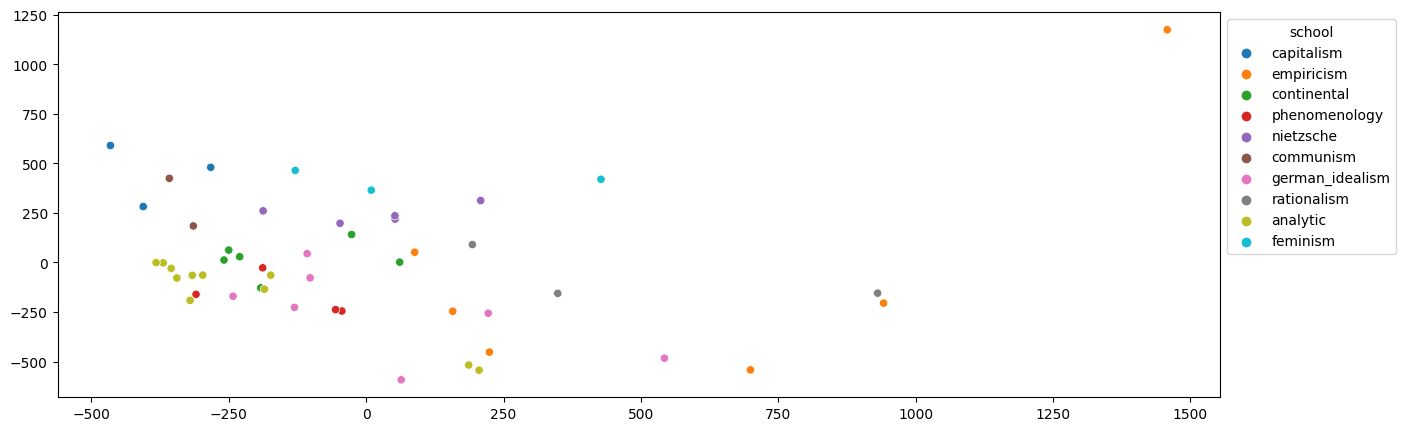

In [319]:
ax = sns.scatterplot(x=reduced_pca[:,0], y=reduced_pca[:,1], hue=df.school)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

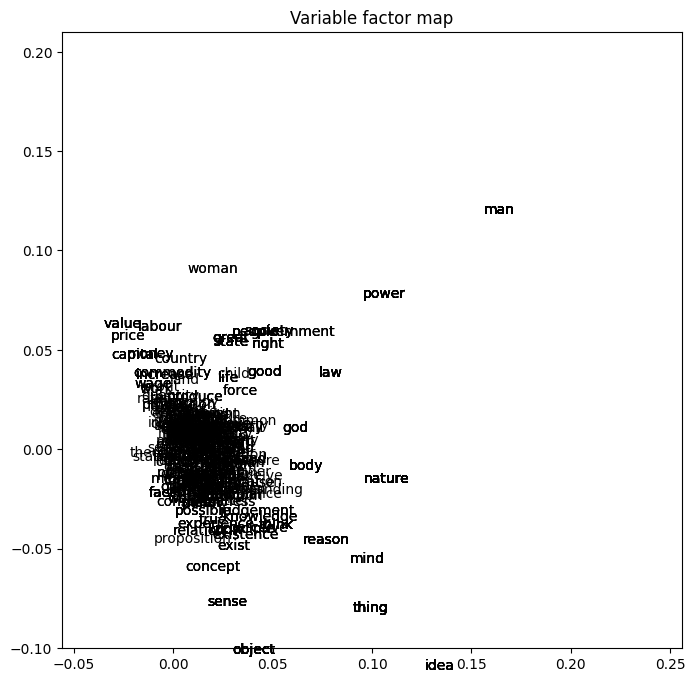

In [320]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    plt.text(pca.components_[0, i],
             pca.components_[1, i],
             final_df.columns.values[i])


plt.xlim((-0.1,0.3))
plt.ylim((-0.1, 0.21))
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

**Exercice**:
1. Perform the projection and vizualization using TSNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) instead of a PCA.
2. Color the graph per author.
3. Add the title of each book using plt.annotate.
4. Can you infer anything regarding the distribution in the reduced space ?

### Clusterize

**Exercice**:
1. Perform a kmeans on the dataset using 10 clusters and assign the column labels as a column called `kmeans_label`.
2. Provide the list of titles / author / school within each cluster.
3. Give the 10 words with the highest term frequency per cluster.
4. Conclude regarding overlap in topics.

In [321]:
from sklearn.cluster import KMeans

In [322]:
inertias = []
for k in range(2, 20):
    kmeans= KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(final_df)
    inertias.append(kmeans.inertia_)

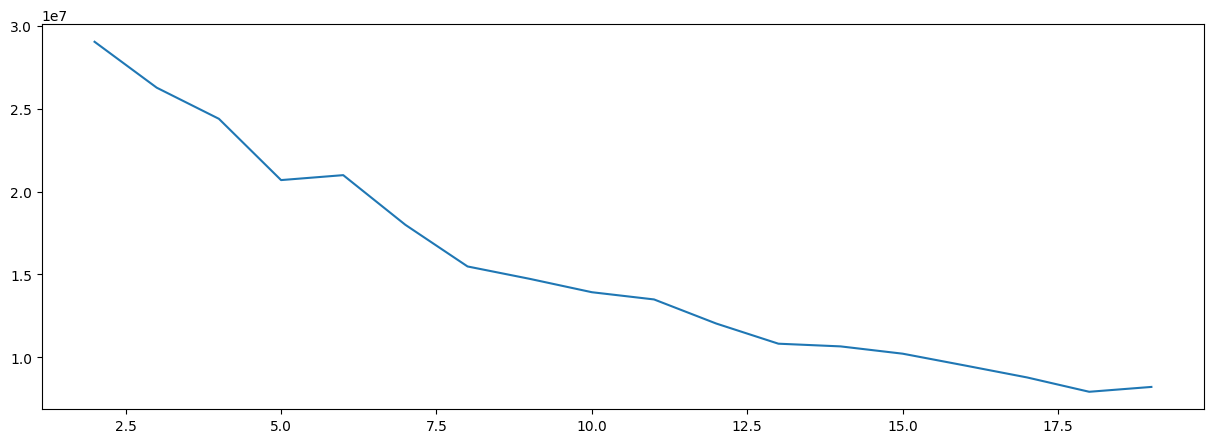

In [323]:
plt.plot(range(2, 20), inertias)

In [324]:
kmeans= KMeans(n_clusters=11, n_init="auto")
kmeans.fit(final_df)
labels = kmeans.labels_

In [325]:
final_df["labels"] = labels
final_df["title"] = df["title"].values
final_df["school"] = df["school"].values
final_df["author"] = df["author"].values

/tmp/ipykernel_198839/3160197531.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_198839/3160197531.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_198839/3160197531.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [326]:
final_df.groupby(["labels", "school"]).count()["title"]/final_df.groupby("school").count()["title"]*100

labels  school         
0       continental         16.666667
1       analytic             9.090909
2       continental         16.666667
        empiricism          33.333333
        feminism           100.000000
        nietzsche          100.000000
        rationalism         66.666667
3       empiricism          16.666667
4       empiricism          33.333333
        rationalism         33.333333
5       german_idealism     28.571429
6       capitalism         100.000000
        communism           50.000000
7       analytic            72.727273
        communism           50.000000
        continental         66.666667
        german_idealism     57.142857
        phenomenology       50.000000
8       german_idealism     14.285714
9       analytic            18.181818
        empiricism          16.666667
10      phenomenology       50.000000
Name: title, dtype: float64

In [328]:
for label in pd.unique(final_df.labels.sort_values()):
    print(f"=== Cluster {label}")
    columns = final_df.drop(["title","author","school"], axis=1).groupby("labels").sum().loc[label,:].sort_values(ascending=False).drop_duplicates()[:10].index.to_list()
    print(columns)
    print(final_df[final_df.labels == label][['title', "author"]])

=== Cluster 0
['language', 'form', 'representation', 'thing', 'man', 'order', 'sign', 'word', 'relation', 'possible']
                              title    author
thought_school                               
continental     The Order Of Things  Foucault
=== Cluster 1
['know', 'proposition', 'believe', 'certain', 'mean', 'hand', 'like', 'thing', 'language', 'word']
                       title        author
thought_school                            
analytic        On Certainty  Wittgenstein
=== Cluster 2
['man', 'woman', 'god', 'great', 'thing', 'reason', 'life', 'good', 'know', 'idea']
                                                title          author
thought_school                                                       
empiricism                 A Treatise Of Human Nature            Hume
nietzsche                        Beyond Good And Evil       Nietzsche
empiricism      Dialogues Concerning Natural Religion            Hume
nietzsche                                   Ecce Homo 

## Bonus: digging deeper into spacy 
Spacy offers a lot of features that go beyond what we can see in a 6 hours session.

You can however easily experiment using the data provided within this session.